# Network Topology Visualization

Draws and prints information about the various network topologies in Cloudscope.

In [1]:
%matplotlib inline

import os
import sys
import json 
import networkx as nx

from networkx.readwrite import json_graph

# Modify the Notebook path
sys.path.append(os.path.join(os.getcwd(), ".."))

from cloudscope.viz import draw_topology

In [2]:
FIXTURES = os.path.join("..", "deploy", "data")

def get_topologies(fixtures=FIXTURES):
    for name in os.listdir(fixtures):
        if name.endswith('.json'):
            yield os.path.join(fixtures, name)

            
def load_topology(path):
    with open(path, 'r') as f:
        data = json.load(f)
        G = json_graph.node_link_graph(data)
        return G, data['meta']

In [3]:
# Draw all the topologies
def print_topology(path):
    G, meta = load_topology(path)
    print meta['title']
    print meta['description']

    draw_topology(G)

In [6]:
# Show the Index
for path in get_topologies(): print path

../deploy/data/backbone.json
../deploy/data/bottleneck.json
../deploy/data/causal.json
../deploy/data/division.json
../deploy/data/eventual.json
../deploy/data/origin.json
../deploy/data/raft.json
../deploy/data/simulation.json


Backbone Simulation
A strong quroum backbone across locations, with causal work horses.


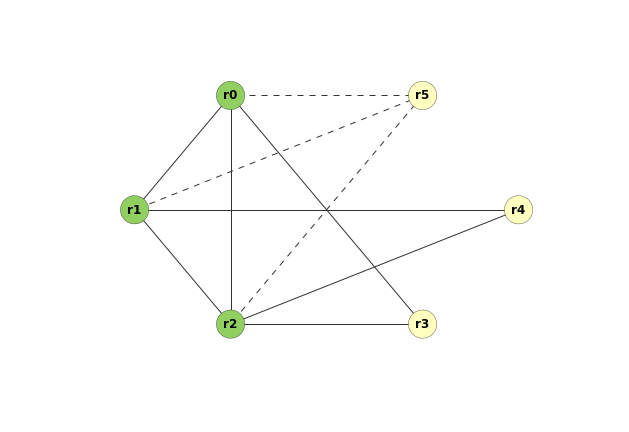

In [7]:
print_topology('../deploy/data/backbone.json')

Bottleneck Simulation
A causally consistent node that is a bottleneck between eventual and strong.


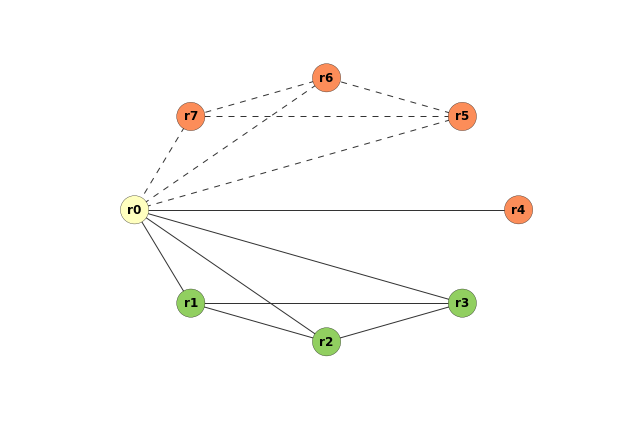

In [8]:
print_topology('../deploy/data/bottleneck.json')

Causally Consistent
Single Consistency Type: A Causally Consistent Data Center.


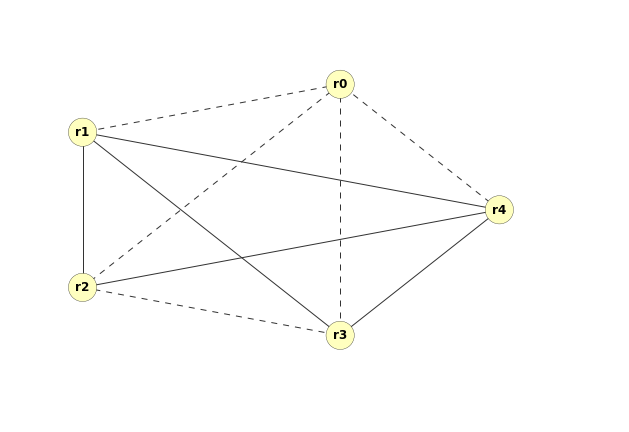

In [9]:
print_topology('../deploy/data/causal.json')

Taking Sides
A topology with two strong sides, surrounded by eventual.


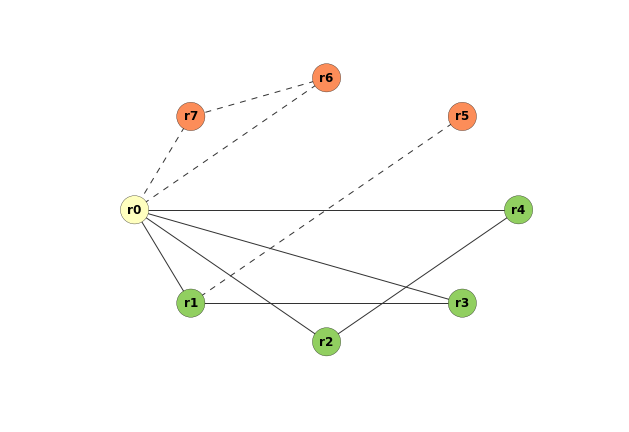

In [10]:
print_topology('../deploy/data/division.json')

Eventually There
Single Consistency Type: An Eventually Consistent Data Center.


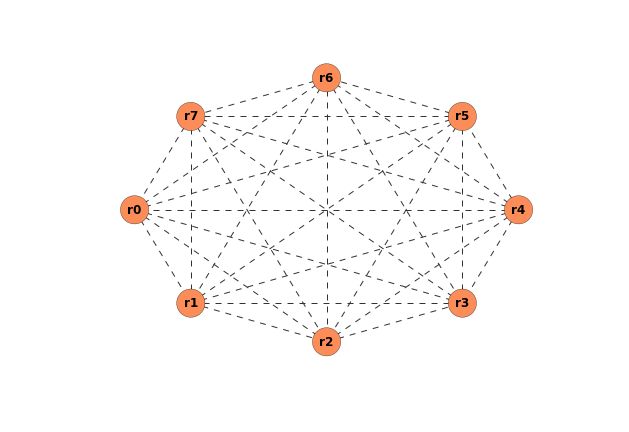

In [11]:
print_topology('../deploy/data/eventual.json')

Origin Simulation
An attempt at a realistic initial toplogy.


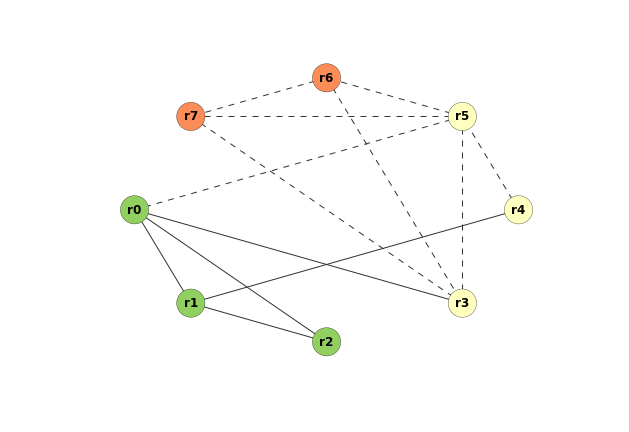

In [12]:
print_topology('../deploy/data/origin.json')

Raft Quorum
Single Consistency Type: Strong Raft Consensus.


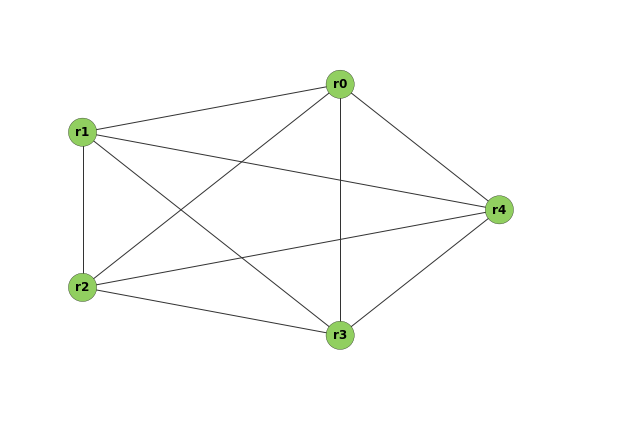

In [13]:
print_topology('../deploy/data/raft.json')

Origin Simulation
An attempt at a realistic initial toplogy.


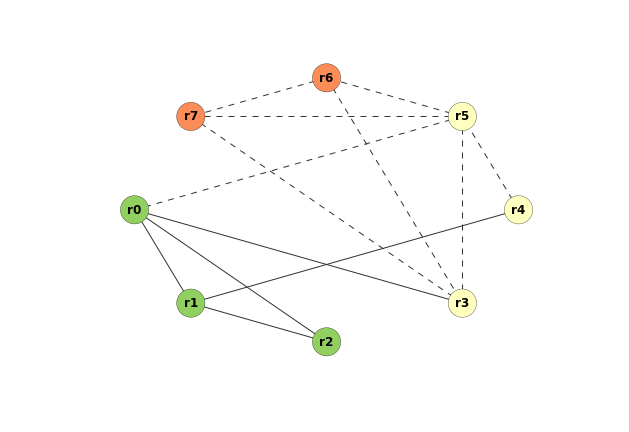

In [14]:
print_topology('../deploy/data/simulation.json')